In [17]:
import requests
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### API Data Fetching

In [18]:
#API Key for OpenWeatherMap
api_key = "545566ffb0179879f5d6f06f1a0a4445"
#List of cities for weather data
cities = [
          "Vijayawada, India",
          "Guntur, India",
          "Amaravathi, India",
          "Visakhapatnam, India",
          "Kurnool, India",
          "Mumbai, India",
          "Hyderabad, India",
          "Bengaluru, India",
          "Delhi, India",
          "London, United Kingdom",
          "Paris, France",
          "New York, United States",
          "Tokyo, Japan",
          "Beijing, China",
          "Istanbul, Turkey",
          "Moscow, Russia",
          "Berlin, Germany",
          "Bangkok, Thailand",
          "Rome, Italy",
          "Madrid, Spain",
          "Mexico City, Mexico",
          "Shanghai, China",
          "Buenos Aires, Argentina",
          "Sydney, Australia",
          "Johannesburg, South Africa",
          "Mawsynram, India",
          "Cherrapunji, India",
          "Panama City, Panama",
          "Puerto Lopez, Ecuador",
          "Sydney, Australia"
          ]

In [19]:
city=np.sort(cities)
print(len(city))

30


In [20]:
for location in cities:
    weather_endpoint = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}"
    weather_data = requests.get(weather_endpoint).json()
    print(weather_data)

{'coord': {'lon': 80.6167, 'lat': 16.5167}, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03d'}], 'base': 'stations', 'main': {'temp': 309.12, 'feels_like': 315.77, 'temp_min': 309.12, 'temp_max': 309.12, 'pressure': 1008, 'humidity': 49}, 'visibility': 6000, 'wind': {'speed': 2.57, 'deg': 150}, 'clouds': {'all': 40}, 'dt': 1682408219, 'sys': {'type': 1, 'id': 9207, 'country': 'IN', 'sunrise': 1682381769, 'sunset': 1682427284}, 'timezone': 19800, 'id': 1253184, 'name': 'Vijayawada', 'cod': 200}
{'coord': {'lon': 80.45, 'lat': 16.3}, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03d'}], 'base': 'stations', 'main': {'temp': 309.09, 'feels_like': 311.5, 'temp_min': 309.09, 'temp_max': 309.09, 'pressure': 1008, 'humidity': 38, 'sea_level': 1008, 'grnd_level': 1005}, 'visibility': 10000, 'wind': {'speed': 6.26, 'deg': 169, 'gust': 5.22}, 'clouds': {'all': 41}, 'dt': 1682408123, 'sys': {'type': 1, 'id': 9207, 'co

In [21]:
weather_list = []


In [22]:
for location in cities:
    forecast_endpoint = f"http://api.openweathermap.org/data/2.5/forecast?q={location}&appid={api_key}"

    forecast_data = requests.get(forecast_endpoint).json()

    for i in range(0, 40):
        date = datetime.fromtimestamp(forecast_data["list"][i]["dt"]).strftime('%Y-%m-%d %H:%M:%S')
        location = forecast_data["city"]["name"]
        min_temp = forecast_data["list"][i]["main"]["temp_min"]
        max_temp = forecast_data["list"][i]["main"]["temp_max"]
        wind_direction = forecast_data["list"][i]["wind"]["deg"]
        wind_speed = forecast_data["list"][i]["wind"]["speed"]
        humidity = forecast_data["list"][i]["main"]["humidity"]
        pressure = forecast_data["list"][i]["main"]["pressure"]
        cloud = forecast_data["list"][i]["clouds"]["all"]
        temperature = forecast_data["list"][i]["main"]["temp"]
        
        if "rain" in forecast_data["list"][i]:
          rain = 1
        else:
          rain = 0
        
        if i + 8 >= 40:
          tomorrow_rain = 0
        elif "rain" in forecast_data["list"][i + 8]:
          tomorrow_rain = 1
        else:
          tomorrow_rain = 0

        weather_dict = {
          "Date": date,
          "Location": location,
          "Min_Temperature (C)": min_temp - 273.15,
          "Max_Temperature (C)": max_temp - 273.15,
          "Wind_Direction (°)": wind_direction,
          "Wind_Speed (m/s)": wind_speed,
          "Humidity (%)": humidity,
          "Pressure (hPa)": pressure,
          "Cloud (%)": cloud,
          "Temperature (C)": temperature - 273.15,
          "Today_Rain": rain,
          "Tomorrow_Rain": tomorrow_rain
        }
        weather_list.append(weather_dict)

In [23]:
data = pd.DataFrame(weather_list)
print(data)

                     Date    Location  Min_Temperature (C)  \
0     2023-04-25 14:30:00  Vijayawada                34.99   
1     2023-04-25 17:30:00  Vijayawada                33.16   
2     2023-04-25 20:30:00  Vijayawada                28.76   
3     2023-04-25 23:30:00  Vijayawada                27.28   
4     2023-04-26 02:30:00  Vijayawada                26.59   
...                   ...         ...                  ...   
1195  2023-04-29 23:30:00      Sydney                16.83   
1196  2023-04-30 02:30:00      Sydney                16.74   
1197  2023-04-30 05:30:00      Sydney                17.68   
1198  2023-04-30 08:30:00      Sydney                21.27   
1199  2023-04-30 11:30:00      Sydney                19.63   

      Max_Temperature (C)  Wind_Direction (°)  Wind_Speed (m/s)  Humidity (%)  \
0                   35.97                 148              5.21            49   
1                   35.03                 162              4.86            46   
2           

####          Exploratory Data Analysis

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1200 non-null   object 
 1   Location             1200 non-null   object 
 2   Min_Temperature (C)  1200 non-null   float64
 3   Max_Temperature (C)  1200 non-null   float64
 4   Wind_Direction (°)   1200 non-null   int64  
 5   Wind_Speed (m/s)     1200 non-null   float64
 6   Humidity (%)         1200 non-null   int64  
 7   Pressure (hPa)       1200 non-null   int64  
 8   Cloud (%)            1200 non-null   int64  
 9   Temperature (C)      1200 non-null   float64
 10  Today_Rain           1200 non-null   int64  
 11  Tomorrow_Rain        1200 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 112.6+ KB


In [25]:
print(data.isnull().sum())

Date                   0
Location               0
Min_Temperature (C)    0
Max_Temperature (C)    0
Wind_Direction (°)     0
Wind_Speed (m/s)       0
Humidity (%)           0
Pressure (hPa)         0
Cloud (%)              0
Temperature (C)        0
Today_Rain             0
Tomorrow_Rain          0
dtype: int64


In [26]:
print(data['Today_Rain'].unique())

[0 1]


In [27]:
print(data['Today_Rain'].groupby)

<bound method Series.groupby of 0       0
1       0
2       0
3       0
4       0
       ..
1195    1
1196    1
1197    0
1198    0
1199    1
Name: Today_Rain, Length: 1200, dtype: int64>


In [28]:
rslt_df = data.loc[data['Tomorrow_Rain'] != 0]
rslt_df

,Date,Location,Min_Temperature (C),Max_Temperature (C),Wind_Direction (°),Wind_Speed (m/s),Humidity (%),Pressure (hPa),Cloud (%),Temperature (C),Today_Rain,Tomorrow_Rain
41,2023-04-25 17:30:00,Guntur,32.37,34.08,167,5.40,40,1007,33,34.08,0,1
92,2023-04-27 02:30:00,Amaravathi,27.33,27.33,116,1.68,82,1007,37,27.33,0,1
100,2023-04-28 02:30:00,Amaravathi,27.46,27.46,164,1.57,79,1008,89,27.46,1,1
101,2023-04-28 05:30:00,Amaravathi,27.13,27.13,148,1.02,82,1009,94,27.13,0,1
106,2023-04-28 20:30:00,Amaravathi,29.35,29.35,139,4.15,66,1009,11,29.35,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2023-04-28 17:30:00,Sydney,19.46,19.46,7,5.67,77,1013,95,19.46,0,1
1186,2023-04-28 20:30:00,Sydney,17.70,17.70,344,2.95,71,1011,88,17.70,0,1
1187,2023-04-28 23:30:00,Sydney,17.23,17.23,337,2.63,65,1010,94,17.23,0,1
1188,2023-04-29 02:30:00,Sydney,16.60,16.60,327,2.24,60,1011,88,16.60,0,1


In [29]:
data.describe()

,Min_Temperature (C),Max_Temperature (C),Wind_Direction (°),Wind_Speed (m/s),Humidity (%),Pressure (hPa),Cloud (%),Temperature (C),Today_Rain,Tomorrow_Rain
count,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,21.819175,21.936475,188.670000,3.16390,59.070000,1011.877500,61.513333,21.889767,0.239167,0.195000
std,7.937637,7.947791,98.335112,1.77498,21.274882,5.161689,36.380184,7.960903,0.426753,0.396366
min,2.170000,2.170000,0.000000,0.06000,7.000000,1000.000000,0.000000,2.170000,0.000000,0.000000
25%,15.920000,15.945000,126.000000,1.88000,42.750000,1008.000000,27.000000,15.927500,0.000000,0.000000
50%,21.570000,21.630000,187.000000,2.79500,61.000000,1011.000000,72.000000,21.580000,0.000000,0.000000
75%,28.182500,28.237500,269.000000,4.27000,75.000000,1015.000000,97.250000,28.237500,0.000000,0.000000
max,38.840000,38.840000,360.000000,10.75000,99.000000,1028.000000,100.000000,38.840000,1.000000,1.000000


In [30]:
#feature engineering
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

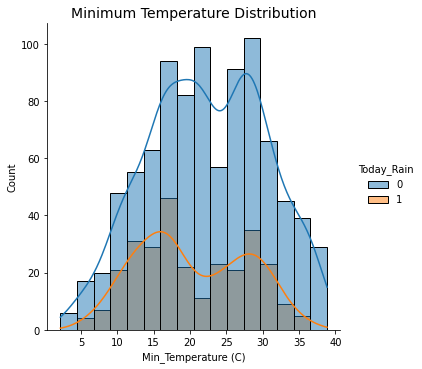

In [31]:
sns.displot(data, x="Min_Temperature (C)", hue='Today_Rain', kde=True)
plt.title("Minimum Temperature Distribution", fontsize = 14)
plt.show()

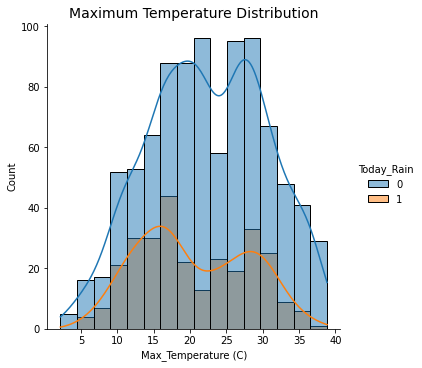

In [32]:
sns.displot(data, x="Max_Temperature (C)", hue='Today_Rain', kde=True)
plt.title("Maximum Temperature Distribution", fontsize = 14)
plt.show()

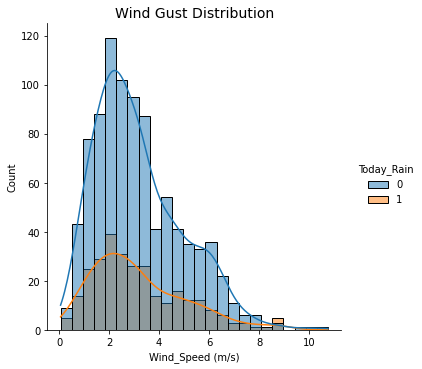

In [33]:
sns.displot(data, x="Wind_Speed (m/s)", hue='Today_Rain', kde=True)
plt.title("Wind Gust Distribution", fontsize = 14)
plt.show()

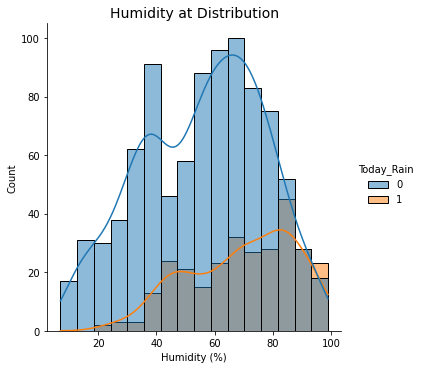

In [34]:
sns.displot(data, x="Humidity (%)", hue='Today_Rain', kde=True)
plt.title("Humidity at Distribution", fontsize = 14)
plt.show()

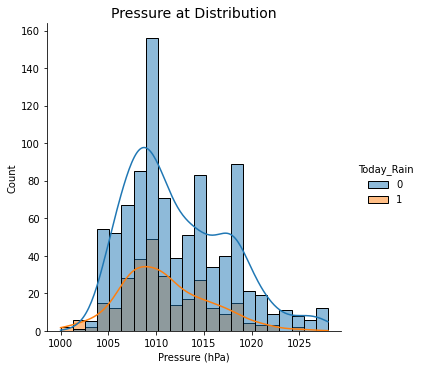

In [35]:
sns.displot(data, x="Pressure (hPa)", hue='Today_Rain', kde=True)
plt.title("Pressure at Distribution", fontsize = 14)
plt.show()

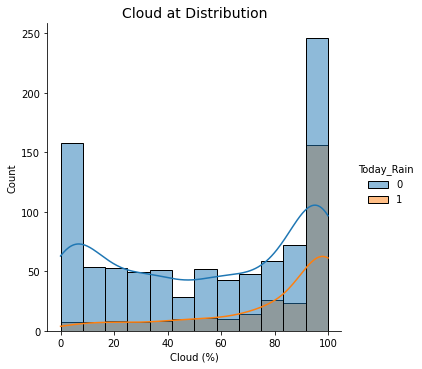

In [36]:
sns.displot(data, x="Cloud (%)", hue='Today_Rain', kde=True)
plt.title("Cloud at Distribution", fontsize = 14)
plt.show()

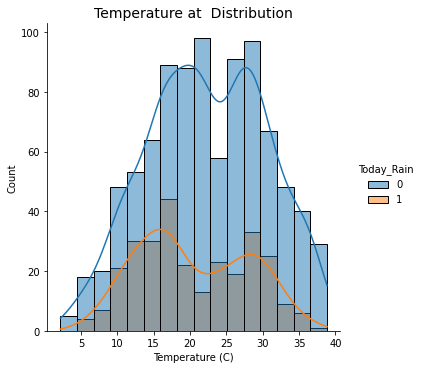

In [37]:
sns.displot(data, x="Temperature (C)", hue='Today_Rain', kde=True)
plt.title("Temperature at  Distribution", fontsize = 14)
plt.show()

### Feature Selection

In [38]:
data=data.drop("Date",axis=1)
data.head(12)

,Location,Min_Temperature (C),Max_Temperature (C),Wind_Direction (°),Wind_Speed (m/s),Humidity (%),Pressure (hPa),Cloud (%),Temperature (C),Today_Rain,Tomorrow_Rain
0,Vijayawada,34.99,35.97,148,5.21,49,1008,40,35.97,0,0
1,Vijayawada,33.16,35.03,162,4.86,46,1008,44,35.03,0,0
2,Vijayawada,28.76,31.16,128,3.86,59,1009,19,31.16,0,0
3,Vijayawada,27.28,27.28,97,2.53,77,1010,6,27.28,0,0
4,Vijayawada,26.59,26.59,104,2.46,81,1008,74,26.59,0,0
5,Vijayawada,25.97,25.97,47,1.40,85,1009,74,25.97,0,0
6,Vijayawada,30.10,30.10,164,2.81,62,1010,78,30.10,0,0
7,Vijayawada,34.64,34.64,184,3.29,39,1009,76,34.64,0,0
8,Vijayawada,37.18,37.18,167,1.87,31,1005,99,37.18,0,0
9,Vijayawada,34.38,34.38,161,5.83,40,1005,87,34.38,0,0


In [39]:

data=pd.get_dummies(data)
data.head(2)

,Min_Temperature (C),Max_Temperature (C),Wind_Direction (°),Wind_Speed (m/s),Humidity (%),Pressure (hPa),Cloud (%),Temperature (C),Today_Rain,Tomorrow_Rain,...,Location_New York,Location_Panama City,Location_Paris,Location_Puerto López,Location_Rome,Location_Shanghai,Location_Sydney,Location_Tokyo,Location_Vijayawada,Location_Visakhapatnam
0,34.99,35.97,148,5.21,49,1008,40,35.97,0,0,...,0,0,0,0,0,0,0,0,1,0
1,33.16,35.03,162,4.86,46,1008,44,35.03,0,0,...,0,0,0,0,0,0,0,0,1,0


In [40]:
weather_corr = data.corr()
weather_corr

,Min_Temperature (C),Max_Temperature (C),Wind_Direction (°),Wind_Speed (m/s),Humidity (%),Pressure (hPa),Cloud (%),Temperature (C),Today_Rain,Tomorrow_Rain,...,Location_New York,Location_Panama City,Location_Paris,Location_Puerto López,Location_Rome,Location_Shanghai,Location_Sydney,Location_Tokyo,Location_Vijayawada,Location_Visakhapatnam
Min_Temperature (C),1.000000,0.997877,0.042079,0.093593,-0.433600,-0.622991,-0.161956,0.998840,-0.103856,-0.097285,...,-0.231283,0.113898,-0.198137,0.067347,-0.129171,-0.098757,-0.102625,-0.100138,0.221047,0.186760
Max_Temperature (C),0.997877,1.000000,0.041048,0.093220,-0.435868,-0.618286,-0.170225,0.998995,-0.102926,-0.095341,...,-0.231672,0.114306,-0.199130,0.065851,-0.128779,-0.097540,-0.103387,-0.102197,0.221091,0.186450
Wind_Direction (°),0.042079,0.041048,1.000000,-0.123882,-0.036888,-0.104580,-0.027176,0.041124,0.004307,-0.015894,...,-0.105076,0.113738,-0.067718,-0.035271,-0.088357,0.047711,-0.021602,0.058763,-0.055532,0.052293
Wind_Speed (m/s),0.093593,0.093220,-0.123882,1.000000,-0.103355,-0.052935,-0.062158,0.094912,-0.003798,-0.040511,...,0.095514,-0.113312,-0.093662,-0.177758,-0.065142,0.026673,0.042080,0.363266,0.014244,0.105824
Humidity (%),-0.433600,-0.435868,-0.036888,-0.103355,1.000000,0.163581,0.145710,-0.433113,0.275211,0.081954,...,-0.009780,0.087800,0.126658,0.234062,0.177740,0.027768,0.114742,0.047197,-0.013491,0.045014
Pressure (hPa),-0.622991,-0.618286,-0.104580,-0.052935,0.163581,1.000000,-0.064279,-0.621327,-0.113529,0.029622,...,0.302232,-0.041479,0.176264,-0.009987,0.015206,0.105183,0.336567,0.050297,-0.153050,-0.140454
Cloud (%),-0.161956,-0.170225,-0.027176,-0.062158,0.145710,-0.064279,1.000000,-0.166128,0.286850,0.138575,...,0.006443,-0.047303,0.155167,0.142784,0.047166,-0.021770,-0.079472,0.014868,-0.098494,-0.071175
Temperature (C),0.998840,0.998995,0.041124,0.094912,-0.433113,-0.621327,-0.166128,1.000000,-0.099706,-0.095168,...,-0.232254,0.113918,-0.198663,0.065503,-0.129175,-0.096289,-0.101648,-0.101260,0.221817,0.187233
Today_Rain,-0.103856,-0.102926,0.004307,-0.003798,0.275211,-0.113529,0.286850,-0.099706,1.000000,0.133301,...,0.004716,-0.104113,-0.006167,0.167960,0.059131,-0.060582,-0.040202,0.059131,-0.104113,-0.049699
Tomorrow_Rain,-0.097285,-0.095341,-0.015894,-0.040511,0.081954,0.029622,0.138575,-0.095168,0.133301,1.000000,...,0.025778,-0.091395,0.014061,0.142950,0.084364,-0.056243,-0.013491,0.025778,-0.091395,-0.032808


In [41]:
cor_target = abs(weather_corr["Tomorrow_Rain"])

relevant_train_features = cor_target[cor_target>0.20]
relevant_train_features

Tomorrow_Rain    1.0
Name: Tomorrow_Rain, dtype: float64

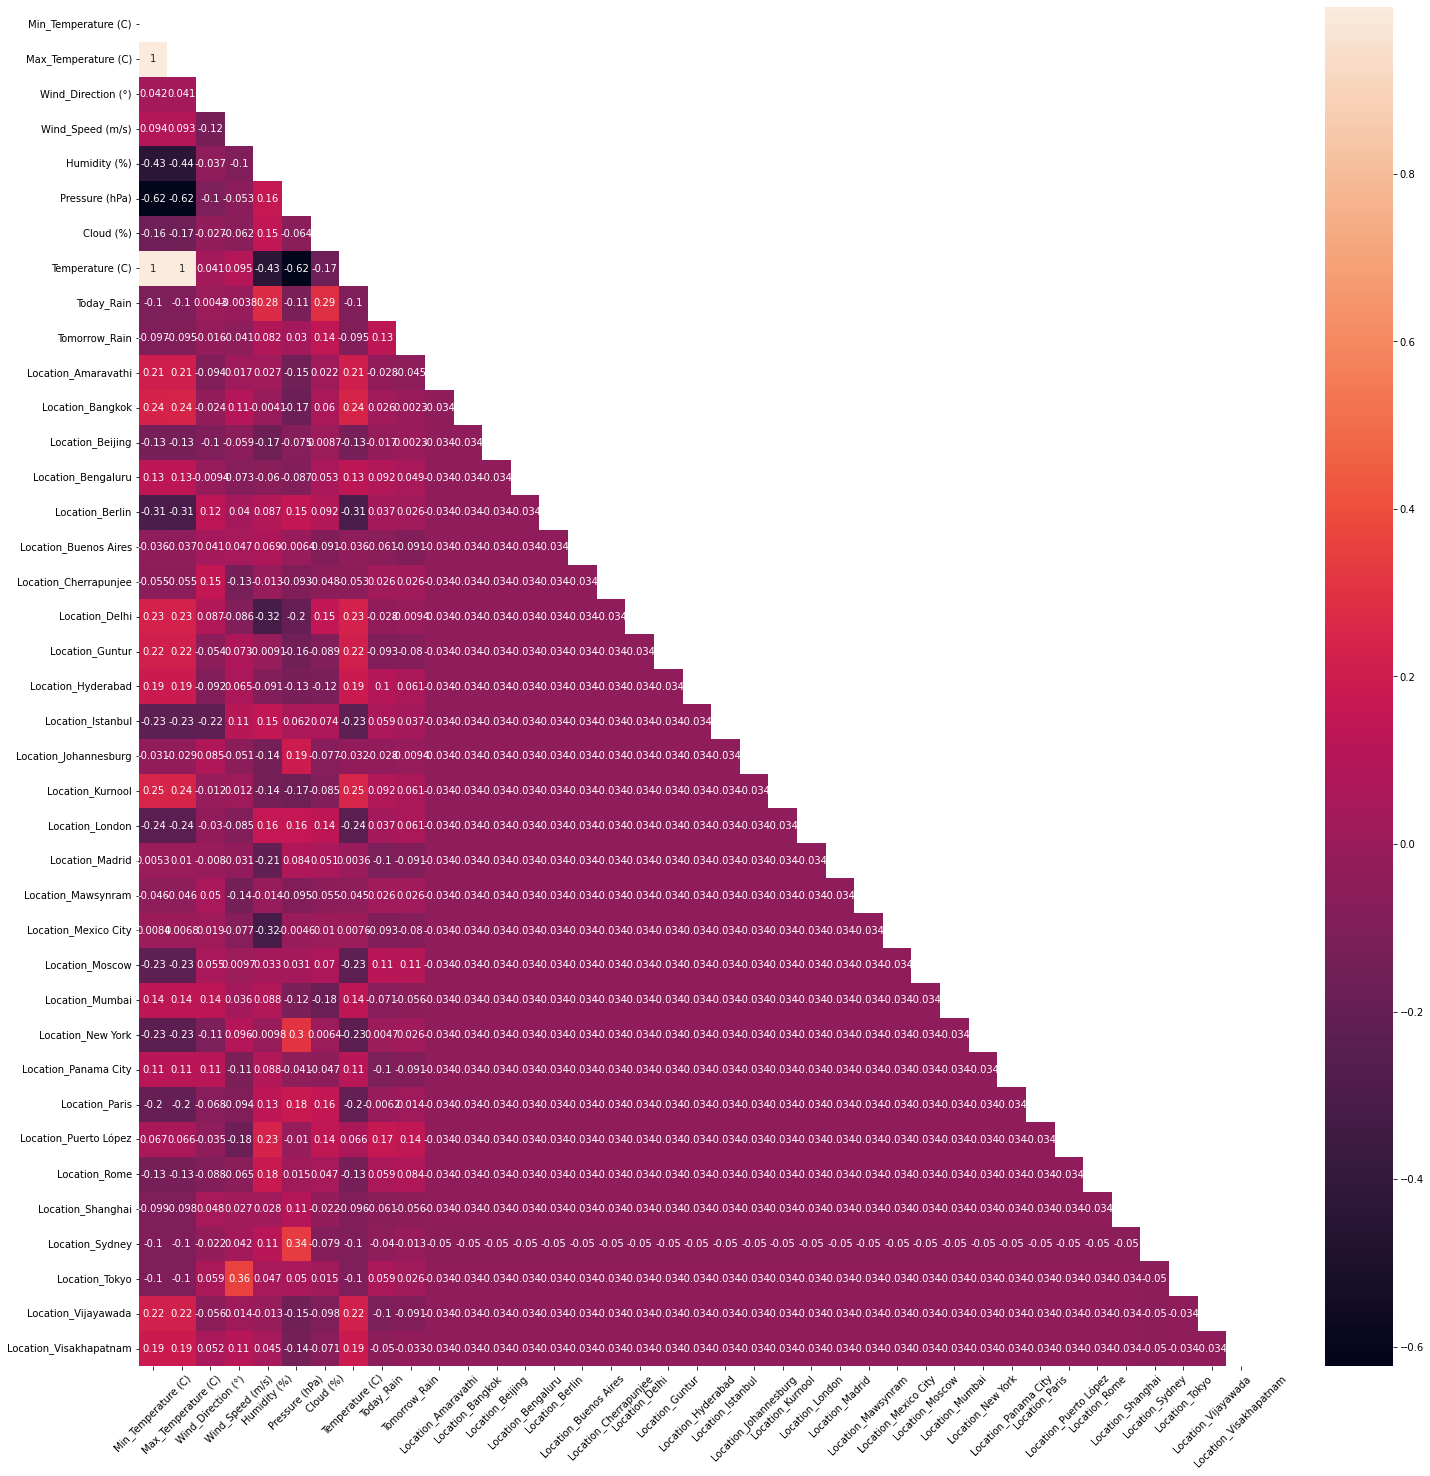

In [42]:
mask = np.triu(np.ones_like(weather_corr, dtype=bool))
plt.figure(figsize=(25,25))
sns.heatmap(weather_corr,annot=True, mask = mask)
plt.xticks(rotation=45)
plt.show()

### Train Test Split

In [43]:
X = data.drop(['Tomorrow_Rain'], axis=1)
y = data['Tomorrow_Rain']


In [44]:
X.columns

Index(['Min_Temperature (C)', 'Max_Temperature (C)', 'Wind_Direction (°)',
       'Wind_Speed (m/s)', 'Humidity (%)', 'Pressure (hPa)', 'Cloud (%)',
       'Temperature (C)', 'Today_Rain', 'Location_Amaravathi',
       'Location_Bangkok', 'Location_Beijing', 'Location_Bengaluru',
       'Location_Berlin', 'Location_Buenos Aires', 'Location_Cherrapunjee',
       'Location_Delhi', 'Location_Guntur', 'Location_Hyderabad',
       'Location_Istanbul', 'Location_Johannesburg', 'Location_Kurnool',
       'Location_London', 'Location_Madrid', 'Location_Mawsynram',
       'Location_Mexico City', 'Location_Moscow', 'Location_Mumbai',
       'Location_New York', 'Location_Panama City', 'Location_Paris',
       'Location_Puerto López', 'Location_Rome', 'Location_Shanghai',
       'Location_Sydney', 'Location_Tokyo', 'Location_Vijayawada',
       'Location_Visakhapatnam'],
      dtype='object')

In [45]:
y.head


<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
1195    0
1196    0
1197    0
1198    0
1199    0
Name: Tomorrow_Rain, Length: 1200, dtype: int64>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(960, 38) (240, 38) (960,) (240,)


In [47]:
X_test.columns
len(X_test.columns)

38

### Classification Models

### Logistic Regression

In [48]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
print(X_train.head)

<bound method NDFrame.head of       Min_Temperature (C)  Max_Temperature (C)  Wind_Direction (°)  \
1011                17.51                17.51                 355   
924                 14.93                14.93                 282   
654                  2.17                 2.17                 260   
716                 30.07                30.07                 175   
681                 30.74                35.23                 165   
...                   ...                  ...                 ...   
733                 17.07                17.07                  70   
1180                14.56                14.56                 313   
1147                29.13                29.13                  25   
527                 21.06                21.06                 199   
1149                24.55                24.55                  32   

      Wind_Speed (m/s)  Humidity (%)  Pressure (hPa)  Cloud (%)  \
1011              1.74            52            1009         3

In [49]:
log_reg_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [50]:
log_reg_model_score = log_reg_model.score(X_test, y_test)
log_reg_model_accuracy = round(log_reg_model_score*100, 2)
print("The classification accuracy of Logistic Regression model is "+ str(log_reg_model_accuracy)+"%")

The classification accuracy of Logistic Regression model is 80.83%


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

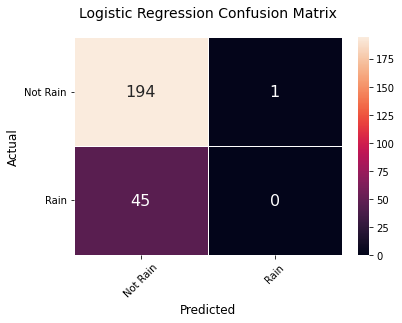

In [51]:
y_pred = log_reg_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
axes = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', linewidths=.5)
class_labels = ['Not Rain', 'Rain']

axes.set_xlabel('Predicted', fontsize=12)
axes.set_ylabel('Actual', fontsize=12)

xtick_marks = np.arange(len(class_labels)) + 0.5
ytick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(xtick_marks)
axes.set_xticklabels(class_labels, rotation=45)

axes.set_yticks(ytick_marks)
axes.set_yticklabels(class_labels, rotation=0)

axes.set_title('Logistic Regression Confusion Matrix', fontsize=14, pad=20)


In [52]:
print('Logistic Regression Classification Report')
print('=========================================')
print()
print(classification_report(y_test, y_pred, target_names=class_labels))

Logistic Regression Classification Report

              precision    recall  f1-score   support

    Not Rain       0.81      0.99      0.89       195
        Rain       0.00      0.00      0.00        45

    accuracy                           0.81       240
   macro avg       0.41      0.50      0.45       240
weighted avg       0.66      0.81      0.73       240



### Decision Tree Classifier

In [53]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [54]:
dtree_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
      dtype=int64)

In [55]:
dtree_model_score = dtree_model.score(X_test, y_test)
dtree_model_accuracy = round(dtree_model_score*100, 2)
print("The classification accuracy of Decision Tree model is "+ str(dtree_model_accuracy)+"%")

The classification accuracy of Decision Tree model is 76.67%


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

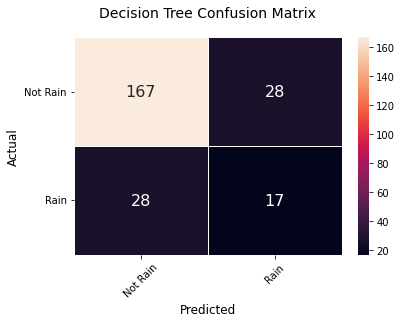

In [56]:
y_pred = dtree_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
axes = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', linewidths=.5)
class_labels = ['Not Rain', 'Rain']

axes.set_xlabel('Predicted', fontsize=12)
axes.set_ylabel('Actual', fontsize=12)

xtick_marks = np.arange(len(class_labels)) + 0.5
ytick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(xtick_marks)
axes.set_xticklabels(class_labels, rotation=45)

axes.set_yticks(ytick_marks)
axes.set_yticklabels(class_labels, rotation=0)

axes.set_title('Decision Tree Confusion Matrix', fontsize=14, pad=20)

In [57]:
print('Decision Tree Classification Report')
print('===================================')
print()
print(classification_report(y_test, y_pred, target_names=class_labels))

Decision Tree Classification Report

              precision    recall  f1-score   support

    Not Rain       0.86      0.86      0.86       195
        Rain       0.38      0.38      0.38        45

    accuracy                           0.77       240
   macro avg       0.62      0.62      0.62       240
weighted avg       0.77      0.77      0.77       240



### Random Forest Classifier

In [58]:
rforest_model = RandomForestClassifier()
rforest_model.fit(X_train, y_train)

RandomForestClassifier()

In [59]:
rforest_model.predict(X_test)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [60]:
rforest_model_score = rforest_model.score(X_test, y_test)
rforest_model_accuracy = round(rforest_model_score*100, 2)
print("The classification accuracy of Random Forest model is "+ str(rforest_model_accuracy)+"%")

The classification accuracy of Random Forest model is 84.17%


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

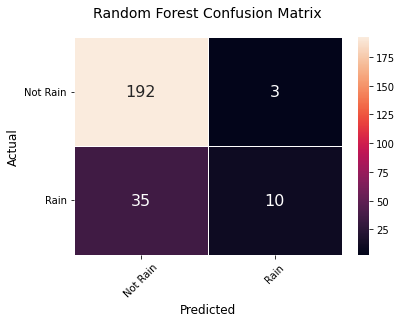

In [61]:
y_pred = rforest_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
axes = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', linewidths=.5)
class_labels = ['Not Rain', 'Rain']

axes.set_xlabel('Predicted', fontsize=12)
axes.set_ylabel('Actual', fontsize=12)

xtick_marks = np.arange(len(class_labels)) + 0.5
ytick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(xtick_marks)
axes.set_xticklabels(class_labels, rotation=45)

axes.set_yticks(ytick_marks)
axes.set_yticklabels(class_labels, rotation=0)

axes.set_title('Random Forest Confusion Matrix', fontsize=14, pad=20)

In [62]:
print('Random Forest Classifier')
print('===================================')
print()
print(classification_report(y_test, y_pred, target_names=class_labels))

Random Forest Classifier

              precision    recall  f1-score   support

    Not Rain       0.85      0.98      0.91       195
        Rain       0.77      0.22      0.34        45

    accuracy                           0.84       240
   macro avg       0.81      0.60      0.63       240
weighted avg       0.83      0.84      0.80       240



In [63]:
accuracy_dict = {'Logistic Regrssion' : log_reg_model_accuracy,
                 'Decision Tree' : dtree_model_accuracy,
                 'Random Forest' : rforest_model_accuracy
                 }
print("Classification Accuracy of All Models")
print('=====================================')
print()
for k, v in accuracy_dict.items():
    print(k,"=",v,"%")

Classification Accuracy of All Models

Logistic Regrssion = 80.83 %
Decision Tree = 76.67 %
Random Forest = 84.17 %


### Save Model

In [64]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(rforest_model, file)